<a href="https://colab.research.google.com/github/dlfelps/ml_portfolio/blob/main/dino_hamster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an introduction to few shot learning.

It has a companion [blog post](https://dlfelps.github.io/2024/06/02/VIT-amster.html).

It is part of Daniel Felps' [ML portfolio](https://github.com/dlfelps/ml_portfolio/tree/main)

# SETUP

In [ ]:
import os
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# download Amstertime dataset
imgs_link = 'https://data.4tu.nl/file/d2ee2551-986a-46bc-8540-b43f5b01ec4d/2482e7f7-90dd-4c1d-9563-637b8d23028d'
if os.path.isdir("./data/"):
    print("Directory already exists")
else:
    os.makedirs("./data/")
    print("Directory created")

print("Downloading from original source")
!wget $imgs_link -O ./data/AmsterTime-v1.0.zip
print("Download completed")
!unzip -q ./data/AmsterTime-v1.0.zip -d ./data/
print("Extraction completed")


Directory created
--2024-04-29 12:53:44--  https://data.4tu.nl/file/d2ee2551-986a-46bc-8540-b43f5b01ec4d/2482e7f7-90dd-4c1d-9563-637b8d23028d
Resolving data.4tu.nl (data.4tu.nl)... 131.180.169.22
Connecting to data.4tu.nl (data.4tu.nl)|131.180.169.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 913361822 (871M) [application/octet-stream]
Saving to: ‘./data/AmsterTime-v1.0.zip’

./data/AmsterTime-v 100%[===================>] 871.05M  25.0MB/s    in 38s     

2024-04-29 12:54:23 (23.1 MB/s) - ‘./data/AmsterTime-v1.0.zip’ saved [913361822/913361822]

Download completed
Extraction completed


# FUNCTIONS

In [ ]:
def load_images_from_folder(folder):

  # images saved as either all jpg or all png
  image_list = list(folder.glob('*.jpg'))
  if image_list:
    pass
  else:
    image_list = list(folder.glob('*.png'))

  return [Image.open(i) for i in sorted(image_list)]


def get_cls_token_for_images(images, processor, model):

  collect = []

  for i in tqdm(images):
    inputs = processor(images=i, return_tensors="pt")
    with torch.no_grad():
      outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    collect.append(last_hidden_states[:,0,:]) # cls token

  return torch.cat(collect)


In [ ]:
def cosine_similarity(u,v):
  # calculates the cosine similarity between two tensors

  # normalize each tensor
  u = torch.nn.functional.normalize(u)
  v = torch.nn.functional.normalize(v)

  # matrix multiplication
  return torch.mm(u,v.T)

def normalize_results(sim):
  # correct ranking is given by the value '0'

  sort_by_id = torch.argsort(sim, descending=True)
  solution = torch.zeros(sim.size(), dtype=torch.int64)
  for i in range(sim.size()[0]):
    solution[i,:] = torch.ones(sim.size()[1], dtype=torch.int64)*i

  return sort_by_id - solution

def total_recall(u,v):
  # returns the n at which each query is found
  # i.e. n=0 means that it was first choice
  sim = cosine_similarity(u, v)
  nr = normalize_results(sim)

  return torch.argwhere(nr == 0)[:,1]

def recall_at_n(u,v,n=1):
  tr = total_recall(u,v)
  total_queries = u.size()[0]
  return len(list(filter(lambda x: x < n, tr))) / total_queries

def closest_match(u,v):
  # returns the closest match in v from the query set u
  sim = cosine_similarity(u, v)
  sort_by_id = torch.argsort(sim, descending=True)

  return sort_by_id[:,0].tolist()

def find_tp_at_one(u,v):
  tr = total_recall(u,v)
  return torch.squeeze(torch.argwhere(tr == 0))

def find_fp_at_one(u,v):
  tr = total_recall(u,v)
  return torch.squeeze(torch.argwhere(tr != 0))

# LOAD DINO

In [ ]:
# load model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

# PROCESS IMAGES

In [ ]:
# calculate and save old_tokens
old_images = load_images_from_folder(Path('./data/old'))
old_tokens = get_cls_token_for_images(old_images, processor, model)
torch.save(old_tokens, 'old_tokens.pt')

100%|██████████| 1231/1231 [19:41<00:00,  1.04it/s]


In [ ]:
# calculate and save new_tokens
new_images = load_images_from_folder(Path('./data/new'))
new_tokens = get_cls_token_for_images(new_images, processor, model)
torch.save(new_tokens, 'new_tokens.pt')

100%|██████████| 1231/1231 [21:30<00:00,  1.05s/it]


In [ ]:
old_tokens = torch.load('old_tokens.pt')
new_tokens = torch.load('new_tokens.pt')
old_images = load_images_from_folder(Path('./data/old'))
new_images = load_images_from_folder(Path('./data/new'))

# RESULTS

In [ ]:

recall_at_n(old_tokens, new_tokens, n=1)

0.429731925264013

In [ ]:
fp_on = set(find_fp_at_one(old_tokens, new_tokens).tolist())
fp_no = set(find_fp_at_one(new_tokens, old_tokens).tolist())
print(f"Number of FP pairs in both directions: {len(fp_no.intersection(fp_on))}")
print(f"Number of unique FP pairs in old->new: {len(fp_on - fp_no)}")
print(f"Number of unique FP pairs in new->old: {len(fp_no - fp_on)}")


Number of FP pairs in both directions: 591
Number of unique FP pairs in old->new: 111
Number of unique FP pairs in new->old: 204


For the 204 unique FP pairs in new->old, lookup the most difficult (using argmax(total_recall)) in the new->old set

In [ ]:
def top10_mismatch(u,v, u_images, v_images):
  # returns the hardest examples that were identified incorrectly in u->v,
  # but correctly in v-> u
  # examples are returned in the following order (query, wrong_result, correct_result)
  fp_uv = set(find_fp_at_one(u, v).tolist())
  tp_vu = set(find_tp_at_one(v, u).tolist())

  candidates = tp_vu.intersection(fp_uv)

  # return the first 3 in top_n that are also in candidates
  tr_uv = total_recall(u, v)
  top_n = torch.argsort(tr_uv, descending=True).tolist()

  cm_uv = closest_match(u, v)
  results = list(filter(lambda x: x in candidates, top_n))[:10]

  acc = []
  for r in results:
    acc.append((u_images[r], v_images[cm_uv[r]], v_images[r]))

  return acc

mismatch_no = top10_mismatch(new_tokens, old_tokens,  new_images,old_images)
mismatch_on = top10_mismatch(old_tokens, new_tokens,old_images, new_images)


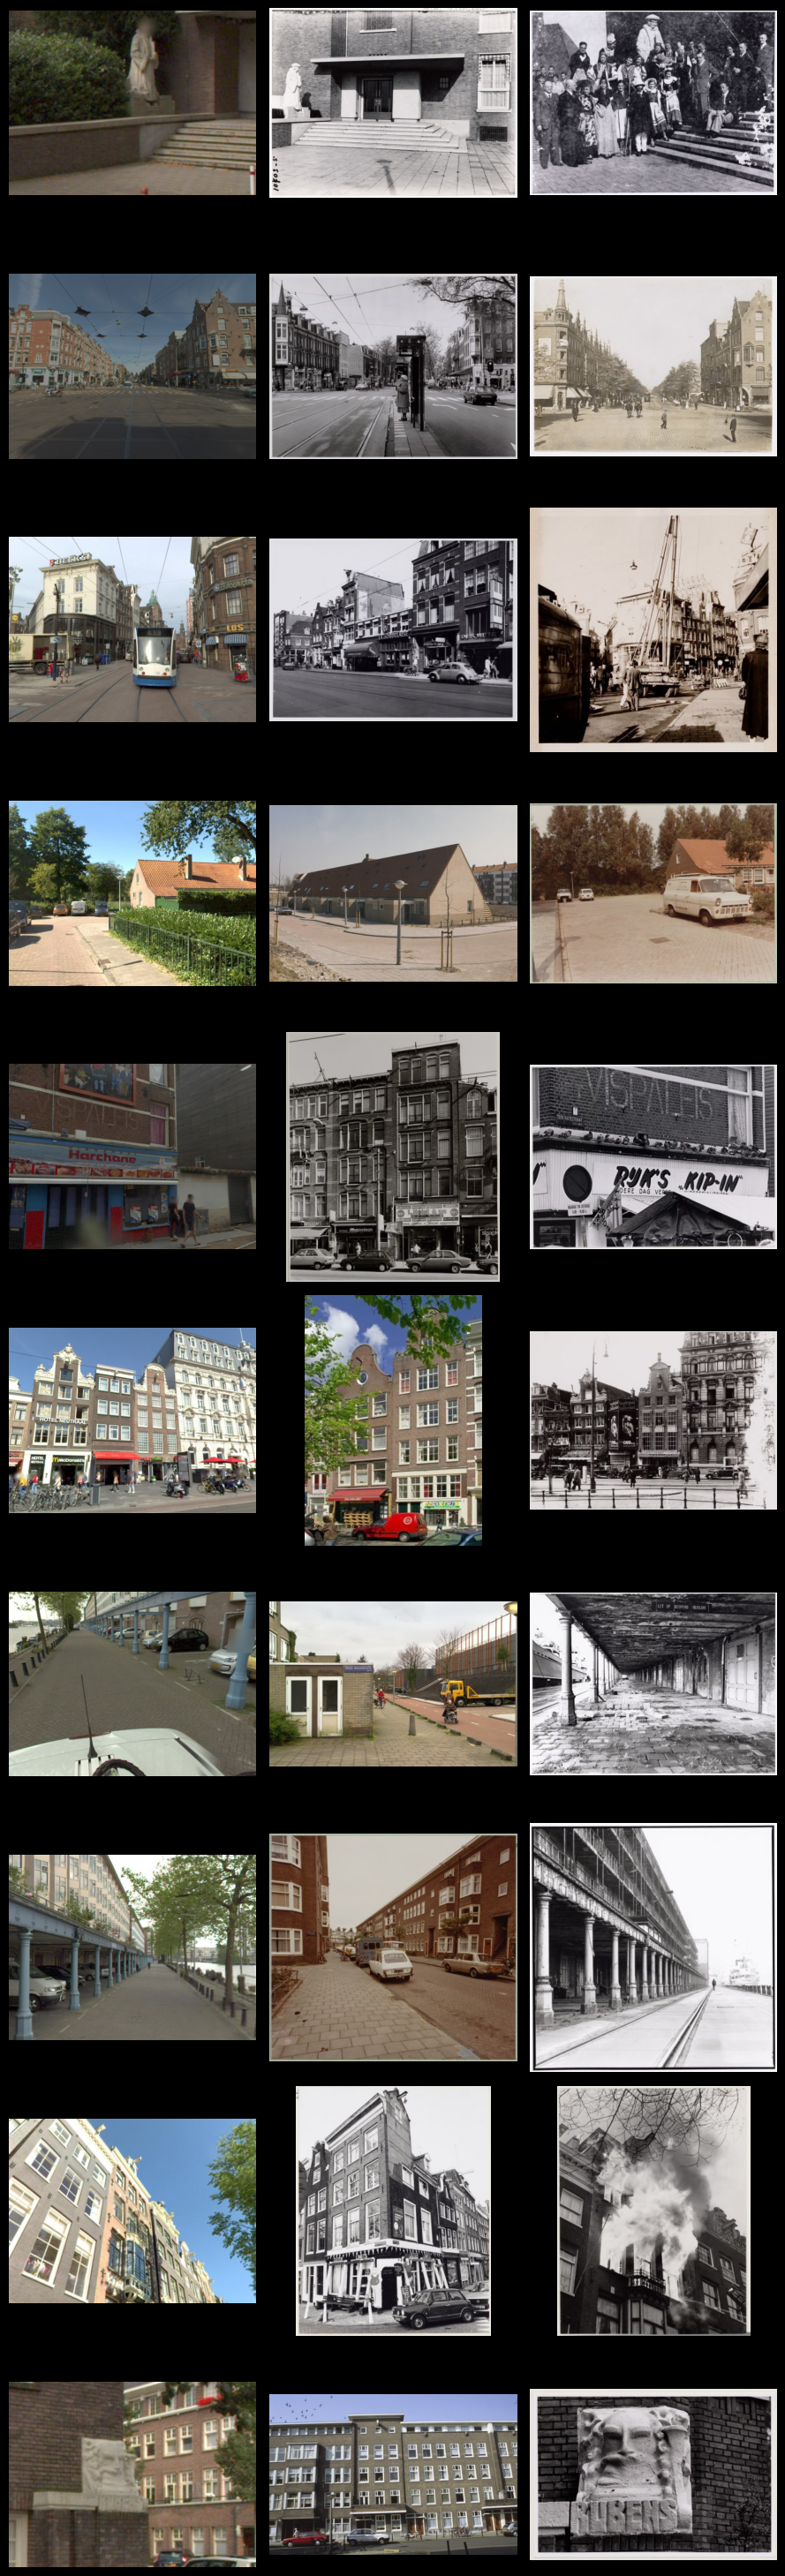

In [ ]:
fig, axs = plt.subplots(10, 3, figsize=(9, 30), facecolor='black', layout='tight' )
def plot_ten_by_three(examples, axs):
  for row,example in enumerate(examples):
    for col, image in enumerate(example):
      axs[row,col].imshow(image)
      axs[row,col].set_axis_off()

plot_ten_by_three(mismatch_no, axs)
plt.savefig('mismatch_no.png', transparent=True)

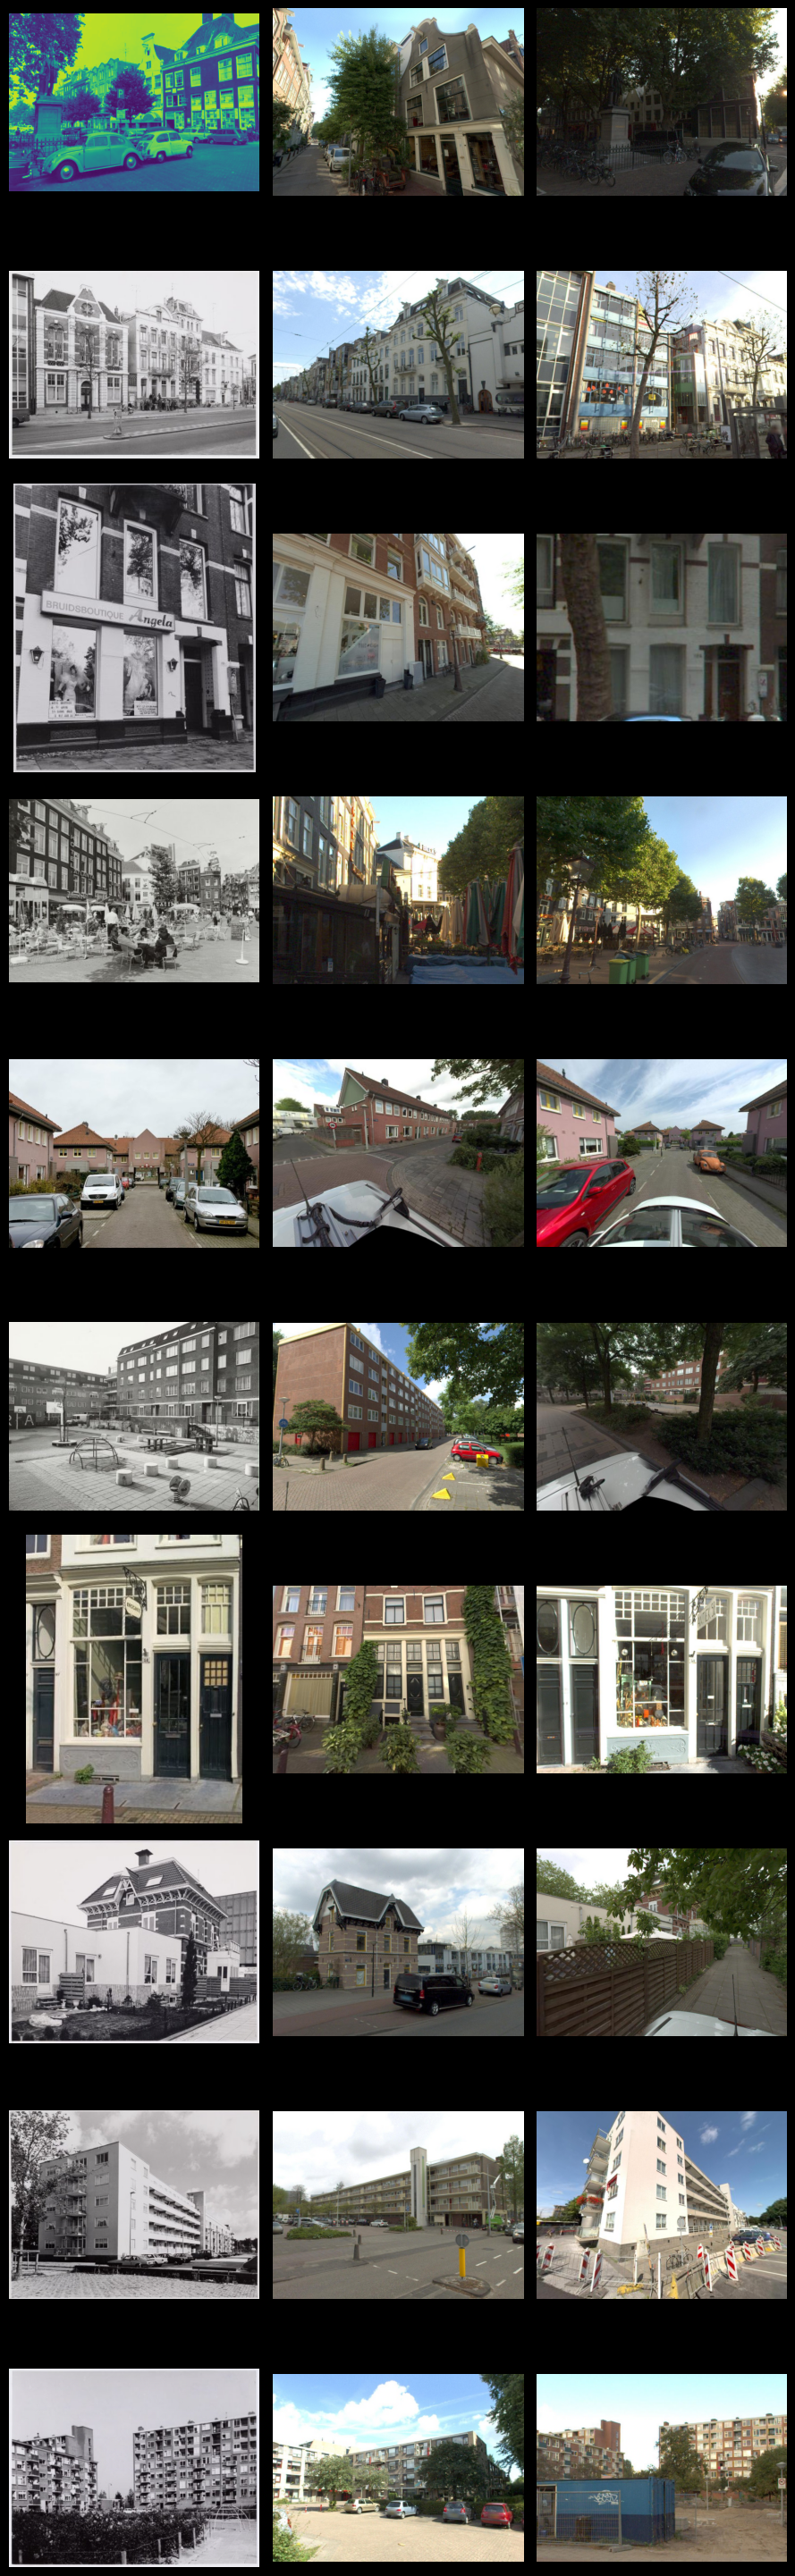

In [ ]:
fig, axs = plt.subplots(10, 3, figsize=(9, 30), facecolor='black', layout='tight' )

plot_ten_by_three(mismatch_on, axs)
plt.savefig('mismatch_on.png', transparent=True)